In [178]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump

In [179]:
dataset_slug = "benjnb/cars-for-sale"
file_name = "Updated_Car_Sales_Data.csv"

df = kagglehub.dataset_load(
  kagglehub.KaggleDatasetAdapter.PANDAS,
  dataset_slug,
  file_name,
)

In [180]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_cleaned = X.copy()

        if 'Fuel Type' in X_cleaned.columns:
            X_cleaned['Fuel Type'] = X_cleaned['Fuel Type'].replace('Petrol', 'Gasoline')

        columns_to_drop = ['Car Make', 'Condition']
        cols_to_drop_exist = [col for col in columns_to_drop if col in X_cleaned.columns]
        if cols_to_drop_exist:
            X_cleaned = X_cleaned.drop(cols_to_drop_exist, axis=1)

        return X_cleaned

In [181]:
class LabelEncodeAndScale(BaseEstimator, TransformerMixin):
    def __init__(self, category_col):
        self.category_col = category_col
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.known_categories_ = None

    def fit(self, X, y=None):
        self.known_categories_ = set(X[self.category_col].unique())
        self.label_encoder.fit(X[self.category_col])

        X_encoded = X.copy()
        X_encoded[self.category_col] = self.label_encoder.transform(X[self.category_col])
        self.scaler.fit(X_encoded[[self.category_col]])
        return self

    def transform(self, X):
        X_encoded = X.copy()

        def map_category(x):
            if x in self.known_categories_:
                return x
            else:
                return list(self.known_categories_)[0]

        X_encoded[self.category_col] = X[self.category_col].map(map_category)
        X_encoded[self.category_col] = self.label_encoder.transform(X_encoded[self.category_col])
        X_scaled = self.scaler.transform(X_encoded[[self.category_col]])
        return X_scaled

    def get_feature_names_out(self, input_features=None):
        return np.array([self.category_col])

In [182]:
class MultiLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_name='Options/Features'):
        self.mlb = MultiLabelBinarizer()
        self.column_name = column_name
        self.feature_names_ = None

    def fit(self, X, y=None):
        features_lists = X[self.column_name].apply(
            lambda x: [f.strip() for f in str(x).split(',')] if pd.notna(x) and str(x).strip() else []
        ).tolist()
        self.mlb.fit(features_lists)
        self.feature_names_ = self.mlb.classes_
        return self

    def transform(self, X):
        features_lists = X[self.column_name].apply(
            lambda x: [f.strip() for f in str(x).split(',')] if pd.notna(x) and str(x).strip() else []
        ).tolist()
        return self.mlb.transform(features_lists)

    def get_feature_names_out(self, input_features=None):
        return np.array([f"multi_label__{feature}" for feature in self.feature_names_])

In [183]:
class Label_Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.le = LabelEncoder()
        self.classes_ = None
        self.default_value_ = None

    def fit(self, X, y=None):
        self.le.fit(X[self.column])
        self.classes_ = set(self.le.classes_)
        self.default_value_ = self.le.transform([self.le.classes_[0]])[0]
        return self

    def transform(self, X):
        X_ = X.copy()

        def map_value(x):
            if x in self.classes_:
                return x
            else:
                return self.le.classes_[0]

        X_[self.column] = X_[self.column].apply(map_value)
        X_[self.column] = self.le.transform(X_[self.column])
        return X_

    def get_feature_names_out(self, input_features=None):
        return np.array([self.column])

In [184]:
class SelectKBestTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, score_func=f_regression, k=10):
        self.score_func = score_func
        self.k = k
        self.selector = SelectKBest(score_func=score_func, k=k)
        self.selected_features_indices_ = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X_df = pd.DataFrame(X)
        else:
            X_df = X

        if hasattr(X, 'columns'):
            self.feature_names_in_ = X.columns.tolist()

        self.selector.fit(X_df, y)
        self.selected_features_indices_ = self.selector.get_support(indices=True)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X_df = pd.DataFrame(X)
        else:
            X_df = X
        return self.selector.transform(X_df)

    def get_support(self, indices=False):
        return self.selector.get_support(indices=indices)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            if self.feature_names_in_ is not None:
                input_features = self.feature_names_in_
            else:
                input_features = [f"x{i}" for i in range(len(self.selected_features_indices_))]

        if isinstance(input_features, np.ndarray):
            input_features = input_features.tolist()

        return np.array([input_features[i] for i in self.selected_features_indices_])

In [185]:
def create_preprocessor():
    label_encoder_col = 'Car Model'
    numeric_cols = ['Year', 'Mileage']
    cat_cols = ['Fuel Type', 'Color', 'Transmission']
    multi_label_col = 'Options/Features'
    binary_col = 'Accident'

    preprocessor = ColumnTransformer(
        transformers=[
            ('label_encode', LabelEncodeAndScale(label_encoder_col), [label_encoder_col]),
            ('numeric', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('multi_label', MultiLabelEncoder(multi_label_col), [multi_label_col]),
            ('binary', Label_Encoder(column=binary_col), [binary_col])
        ],
        remainder='drop',
        verbose_feature_names_out=True
    )
    return preprocessor

In [186]:
def split_data(df, target_column='Price', test_size=0.2, val_size=0.1, random_state=42):
    X = df.drop(columns=[target_column], axis=1)
    y = df[target_column]

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [187]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)


Total de features após preprocessamento: 28

Primeiras linhas dos dados processados:
   label_encode__Car Model  numeric__Year  numeric__Mileage  \
0                -1.412788      -1.439331          0.983844   
1                 0.313129      -1.705265          1.480430   
2                 0.428190       1.485944         -0.885541   
3                 1.089792      -0.907463          0.886428   
4                -0.463534       0.954076          1.536110   

   cat__Fuel Type_Diesel  cat__Fuel Type_Electric  cat__Fuel Type_Gasoline  \
0                    0.0                      1.0                      0.0   
1                    0.0                      1.0                      0.0   
2                    0.0                      0.0                      1.0   
3                    0.0                      1.0                      0.0   
4                    0.0                      0.0                      0.0   

   cat__Fuel Type_Hybrid  cat__Color_Black  cat__Color_Blue  cat__

<Figure size 1000x800 with 0 Axes>

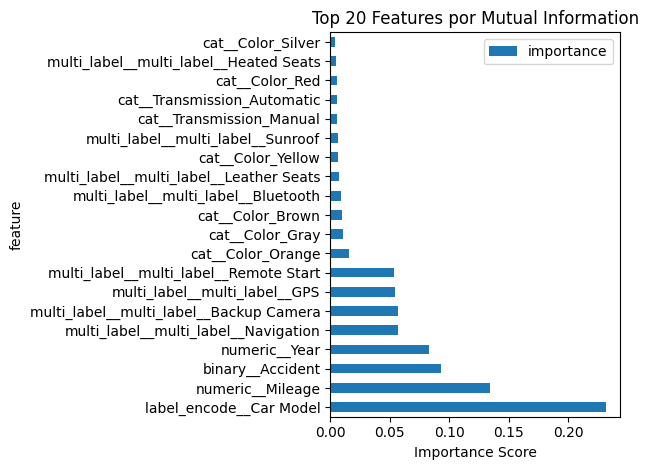

In [188]:
analysis_pipeline = Pipeline(steps=[
    ('cleaning', DataCleaner()),
    ('preprocessing', create_preprocessor())
])

analysis_pipeline.fit(X_train, y_train)
X_train_for_analysis = analysis_pipeline.transform(X_train)
all_feature_names = analysis_pipeline.named_steps['preprocessing'].get_feature_names_out()
X_train_for_analysis = pd.DataFrame(X_train_for_analysis, columns=all_feature_names)

print(f"\nTotal de features após preprocessamento: {len(all_feature_names)}")
print("\nPrimeiras linhas dos dados processados:")
print(X_train_for_analysis.head())

# Calcular importância
importances = mutual_info_regression(X_train_for_analysis, y_train, random_state=42)
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 20 Features mais importantes:")
print(feature_importance_df.head(20))

plt.figure(figsize=(10, 8))
feature_importance_df.head(20).plot(x='feature', y='importance', kind='barh')
plt.xlabel('Importance Score')
plt.title('Top 20 Features por Mutual Information')
plt.tight_layout()
plt.show()

In [189]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
    'rmse': make_scorer(rmse_scorer),
    'r2': make_scorer(r2_score)
}

cv_results = {}

In [190]:
for name, model in models.items():
    print(f"\nAvaliando {name}...")
    
    # Criar pipeline completo para cada modelo
    pipeline = Pipeline(steps=[
        ('cleaning', DataCleaner()),
        ('preprocessing', create_preprocessor()),
        ('regressor', model)
    ])
    
    # Cross-validation com dados brutos
    cv_metrics = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring)
    
    cv_results[name] = {
        "Mean MAE (CV)": cv_metrics['test_mae'].mean(),
        "Std Dev MAE (CV)": cv_metrics['test_mae'].std(),
        "Mean MSE (CV)": cv_metrics['test_mse'].mean(),
        "Std Dev MSE (CV)": cv_metrics['test_mse'].std(),
        "Mean RMSE (CV)": cv_metrics['test_rmse'].mean(),
        "Std Dev RMSE (CV)": cv_metrics['test_rmse'].std(),
        "Mean R² (CV)": cv_metrics['test_r2'].mean(),
        "Std Dev R² (CV)": cv_metrics['test_r2'].std()
    }

cv_df = pd.DataFrame(cv_results).T
print("\nResultados do Cross-Validation:")
print(cv_df.sort_values(by='Mean R² (CV)', ascending=False))


Avaliando Linear Regression...

Avaliando Decision Tree...

Avaliando KNN...

Avaliando Random Forest...

Avaliando Gradient Boosting...

Resultados do Cross-Validation:
                   Mean MAE (CV)  Std Dev MAE (CV)  Mean MSE (CV)  \
Random Forest       16873.988281        371.449707   8.417378e+08   
Gradient Boosting   21858.808272        232.218153   1.277271e+09   
Decision Tree       22174.416939        460.486012   1.617264e+09   
KNN                 26233.054447        206.197932   1.981220e+09   
Linear Regression   33883.126754        332.950712   2.361528e+09   

                   Std Dev MSE (CV)  Mean RMSE (CV)  Std Dev RMSE (CV)  \
Random Forest          5.778673e+07    28995.445471        1000.984549   
Gradient Boosting      4.956455e+07    35732.193777         693.470663   
Decision Tree          9.769318e+07    40196.111824        1239.490623   
KNN                    3.243629e+07    44509.394952         365.490027   
Linear Regression      8.186707e+07    48588

In [191]:
print("\nTuning KNN...")
pipeline_to_tune_knn = Pipeline(steps=[
    ('cleaning', DataCleaner()),
    ('preprocessing', create_preprocessor()),
    ('regressor', KNeighborsRegressor())
])

param_distributions_knn = {
    'regressor__n_neighbors': randint(3, 20),
    'regressor__weights': ['uniform', 'distance']
}

random_search_knn = RandomizedSearchCV(
    pipeline_to_tune_knn,
    param_distributions=param_distributions_knn,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search_knn.fit(X_train, y_train)
best_pipeline_knn = random_search_knn.best_estimator_
print(f"Best params KNN: {random_search_knn.best_params_}")
print(f"Best MSE KNN: {-random_search_knn.best_score_:.2f}")

# Decision Tree
print("\nTuning Decision Tree...")
pipeline_to_tune_dt = Pipeline(steps=[
    ('cleaning', DataCleaner()),
    ('preprocessing', create_preprocessor()),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

param_distributions_dt = {
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 50),
    'regressor__min_samples_leaf': randint(1, 30),
    'regressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'regressor__max_features': ['sqrt', 'log2', None]
}

random_search_dt = RandomizedSearchCV(
    pipeline_to_tune_dt,
    param_distributions=param_distributions_dt,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_dt.fit(X_train, y_train)
best_pipeline_dt = random_search_dt.best_estimator_
print(f"Best params DT: {random_search_dt.best_params_}")
print(f"Best MSE DT: {-random_search_dt.best_score_:.2f}")

# Random Forest
print("\nTuning Random Forest...")
pipeline_to_tune_rf = Pipeline(steps=[
    ('cleaning', DataCleaner()),
    ('preprocessing', create_preprocessor()),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_distributions_rf = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(10, 50),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    pipeline_to_tune_rf,
    param_distributions=param_distributions_rf,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_rf.fit(X_train, y_train)
best_pipeline_rf = random_search_rf.best_estimator_
print(f"Best params RF: {random_search_rf.best_params_}")
print(f"Best MSE RF: {-random_search_rf.best_score_:.2f}")


Tuning KNN...
Best params KNN: {'regressor__n_neighbors': 17, 'regressor__weights': 'uniform'}
Best MSE KNN: 1720792421.09

Tuning Decision Tree...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params DT: {'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 17, 'regressor__max_features': None, 'regressor__min_samples_leaf': 7, 'regressor__min_samples_split': 33}
Best MSE DT: 1045355544.80

Tuning Random Forest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params RF: {'regressor__max_depth': 23, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 241}
Best MSE RF: 956015204.13


In [192]:
tuned_models_evaluation = {}

# KNN
y_pred_tuned_knn = best_pipeline_knn.predict(X_val)
tuned_models_evaluation["Tuned KNN"] = {
    "MAE": mean_absolute_error(y_val, y_pred_tuned_knn),
    "MSE": mean_squared_error(y_val, y_pred_tuned_knn),
    "RMSE": np.sqrt(mean_squared_error(y_val, y_pred_tuned_knn)),
    "R²": r2_score(y_val, y_pred_tuned_knn)
}

# Decision Tree
y_pred_tuned_dt = best_pipeline_dt.predict(X_val)
tuned_models_evaluation["Tuned Decision Tree"] = {
    "MAE": mean_absolute_error(y_val, y_pred_tuned_dt),
    "MSE": mean_squared_error(y_val, y_pred_tuned_dt),
    "RMSE": np.sqrt(mean_squared_error(y_val, y_pred_tuned_dt)),
    "R²": r2_score(y_val, y_pred_tuned_dt)
}

# Random Forest
y_pred_tuned_rf = best_pipeline_rf.predict(X_val)
tuned_models_evaluation["Tuned Random Forest"] = {
    "MAE": mean_absolute_error(y_val, y_pred_tuned_rf),
    "MSE": mean_squared_error(y_val, y_pred_tuned_rf),
    "RMSE": np.sqrt(mean_squared_error(y_val, y_pred_tuned_rf)),
    "R²": r2_score(y_val, y_pred_tuned_rf)
}

tuned_evaluation_df = pd.DataFrame(tuned_models_evaluation).T
print("\nComparação dos Modelos Tunados no Conjunto de Validação:")
print(tuned_evaluation_df.sort_values(by='R²', ascending=False))


Comparação dos Modelos Tunados no Conjunto de Validação:
                              MAE           MSE          RMSE        R²
Tuned Random Forest  17208.412229  9.186005e+08  30308.423648  0.760279
Tuned Decision Tree  17617.933389  9.958699e+08  31557.406607  0.740115
Tuned KNN            25707.112463  1.683021e+09  41024.643701  0.560793


In [193]:
best_model_name = tuned_evaluation_df.sort_values(by='R²', ascending=False).index[0]
print(f"\nMelhor modelo selecionado: {best_model_name}")

model_mapping = {
    "Tuned KNN": best_pipeline_knn,
    "Tuned Decision Tree": best_pipeline_dt,
    "Tuned Random Forest": best_pipeline_rf
}

best_pipeline = model_mapping[best_model_name]

# Avaliar no conjunto de teste
y_pred_test = best_pipeline.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nResultados Finais no Conjunto de Teste ({best_model_name}):")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")
print(f"R-squared (R²): {r2_test:.4f}")
print(f"MAPE: {mape:.2f}%")


Melhor modelo selecionado: Tuned Random Forest

Resultados Finais no Conjunto de Teste (Tuned Random Forest):
Mean Absolute Error (MAE): 17601.22
Mean Squared Error (MSE): 926616861.97
Root Mean Squared Error (RMSE): 30440.38
R-squared (R²): 0.7711
MAPE: 78.52%


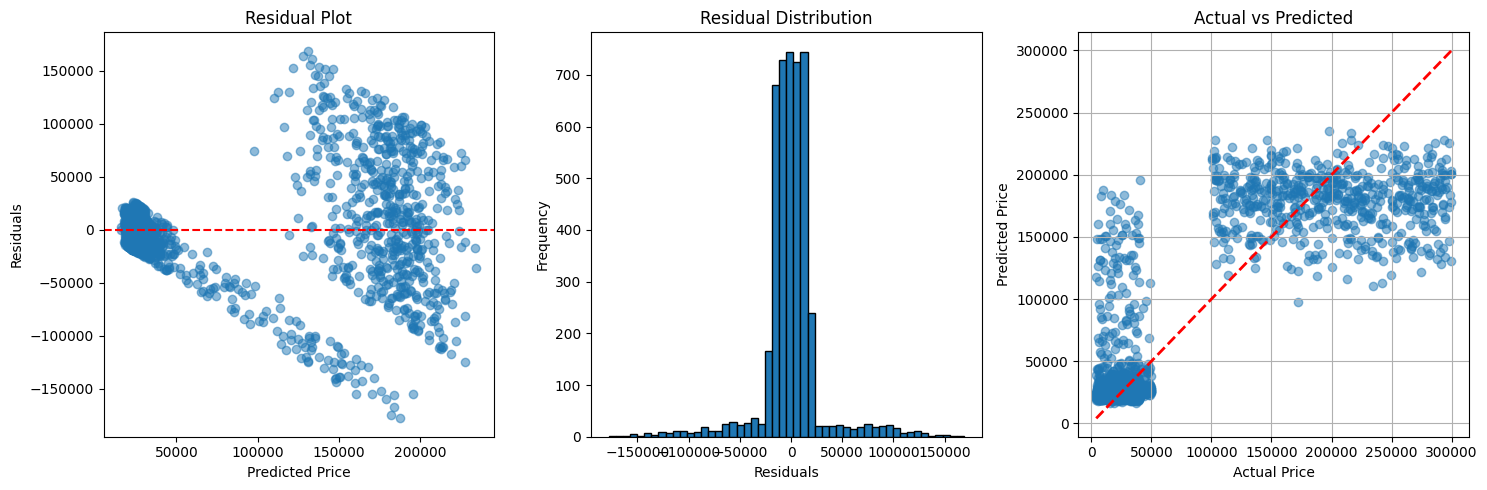

In [194]:
residuals = y_test - y_pred_test

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

In [195]:
model_filename = '../models/best_model.pkl'
dump(best_pipeline, model_filename)
print(f"\nMelhor modelo ({best_model_name}) salvo em: {model_filename}")


Melhor modelo (Tuned Random Forest) salvo em: ../models/best_model.pkl
